In [1]:
%matplotlib inline

import gzip
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import georinex as gr
import xarray as xr


plt.rcParams['figure.figsize'] = (7, 3)
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
def load_sp3_clk(path):
    with gzip.open(path) as sp3:
        ls = sp3.readlines()
    clks = {}
    times = {}
    for line in ls:
        if not line.startswith(b'AS E'):
            continue
        sp = line.split()
        svn = str(sp[1], encoding='ascii')
        t = [str(a, encoding='ascii') for a in sp[2:8]]
        t = np.datetime64(f'{t[0]}-{t[1]}-{t[2]}T{t[3]}:{t[4]}:{t[5]}', 'ns')
        clk = float(sp[9])
        clks.setdefault(svn, []).append(clk)
        times.setdefault(svn, []).append(t)
    return xr.concat((xr.DataArray(clks[svn], coords={'time': times[svn], 'sv': svn}, dims=['time'])
                      for svn in clks), dim='sv')

In [3]:
brdcs = sorted(pathlib.Path('data').glob('BRDC*.rnx.gz'))
brdc = xr.concat((gr.load(b, use='E')[['SVclockBias']] for b in brdcs), dim='time')

In [4]:
sp3s = sorted(pathlib.Path('data').glob('COD*CLK.CLK.gz'))
sp3 = xr.concat((load_sp3_clk(s) for s in sp3s), dim='time')

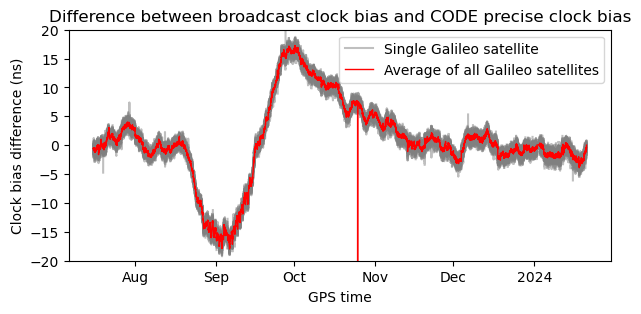

In [5]:
diffs = {}
label = 'Single Galileo satellite'
for sv in sp3.sv.values:
    # handle "aliases": https://github.com/geospace-code/georinex/commit/bd6927c2daba9b268150301b6dd16c8e40f50072
    sv_alias = [k for k in brdc.sv.values if k.startswith(sv)]
    b = brdc['SVclockBias'].sel(sv=sv_alias).mean('sv')
    s = sp3.sel(sv=sv).interp(time=b.time)
    diff = 1e9 * (b - s)
    diffs[sv] = diff
    diff.plot(color='gray', alpha=0.5, label=label)
    label = '_nolegend_'
diffs = xr.concat(diffs.values(), dim='sv')
diff0 = diffs.mean('sv')
diff0.plot(color='red', linewidth=1, label='Average of all Galileo satellites')
plt.title('Difference between broadcast clock bias and CODE precise clock bias')
plt.xlabel('GPS time')
plt.ylabel('Clock bias difference (ns)')
plt.ylim(-20, 20)
plt.legend();

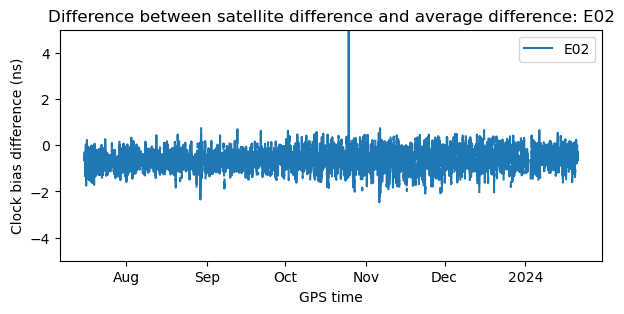

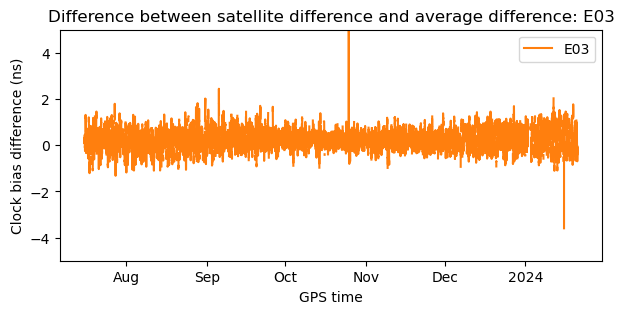

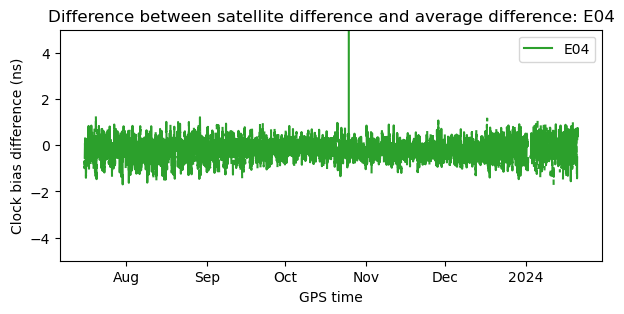

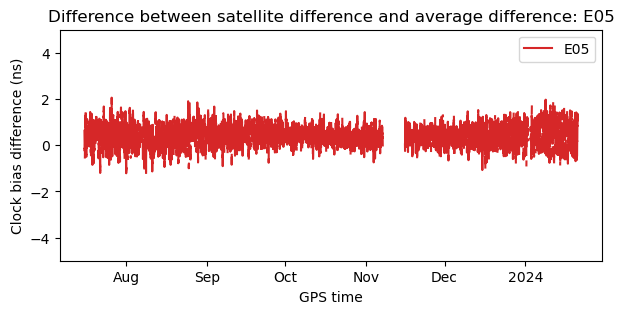

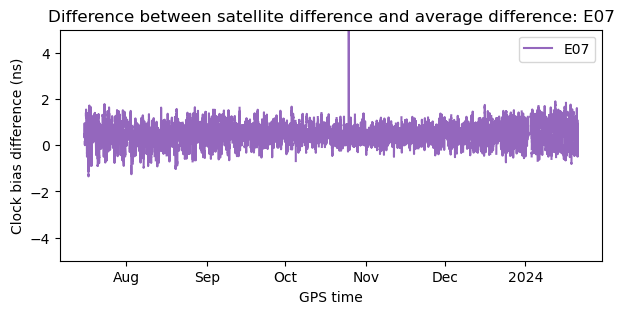

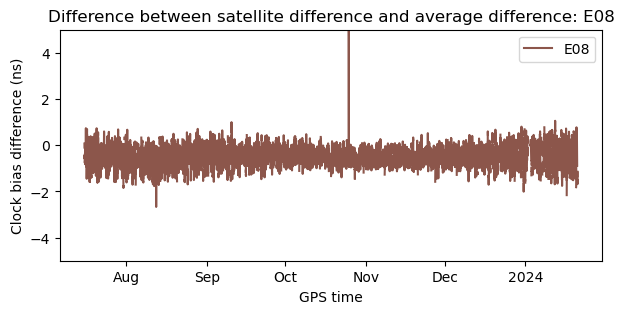

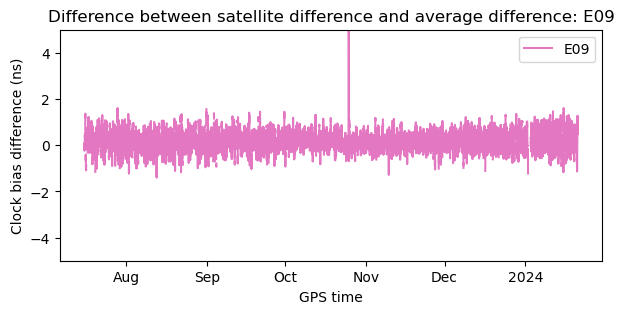

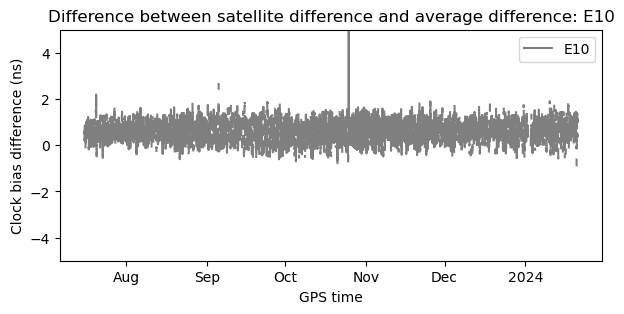

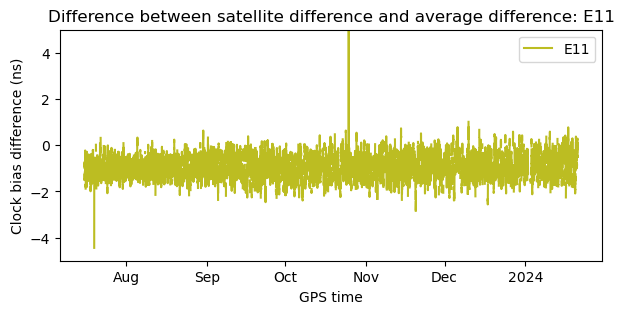

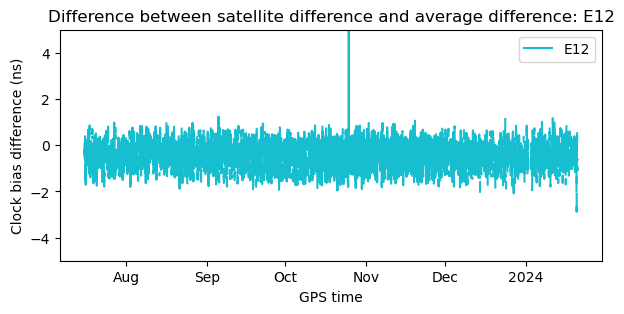

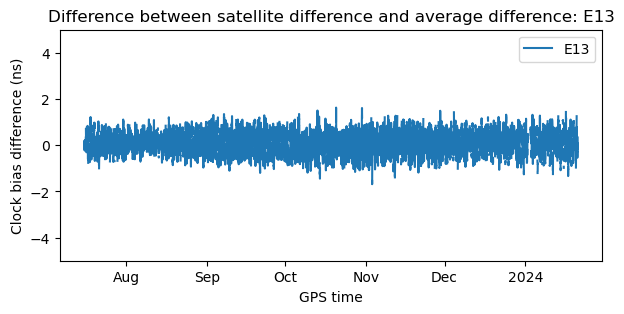

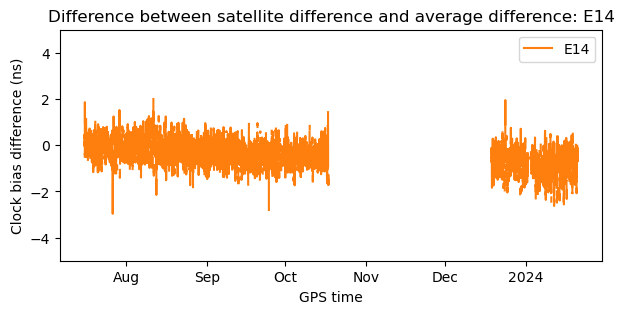

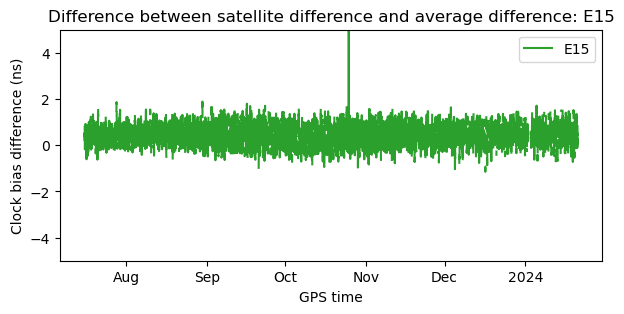

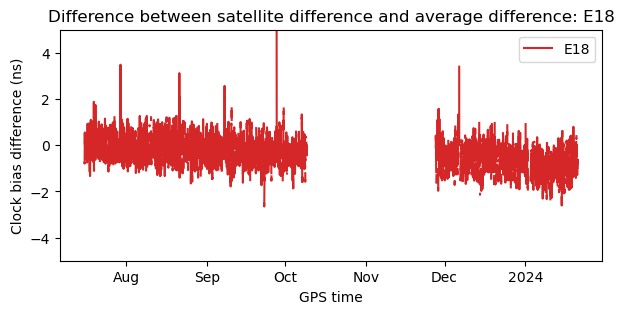

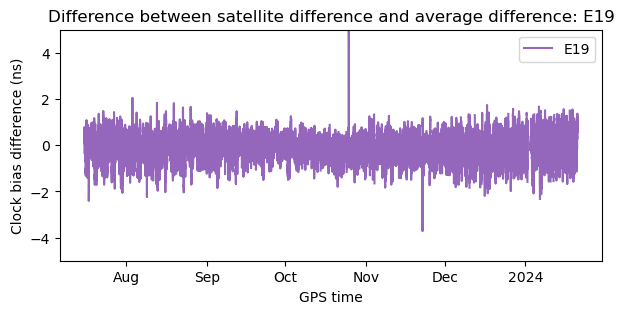

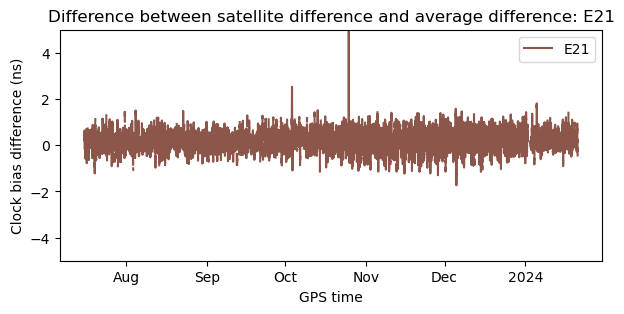

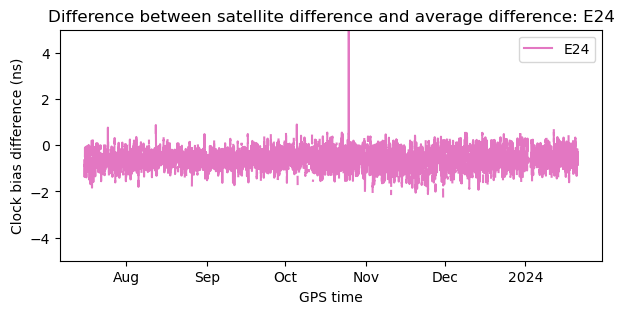

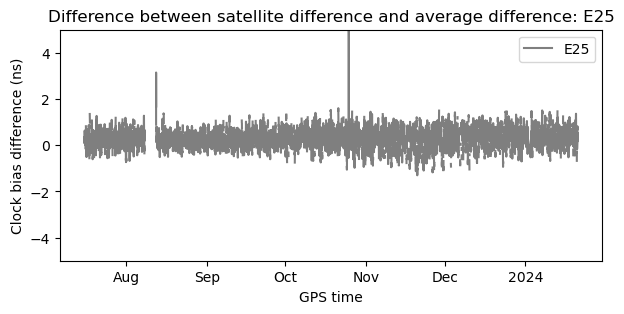

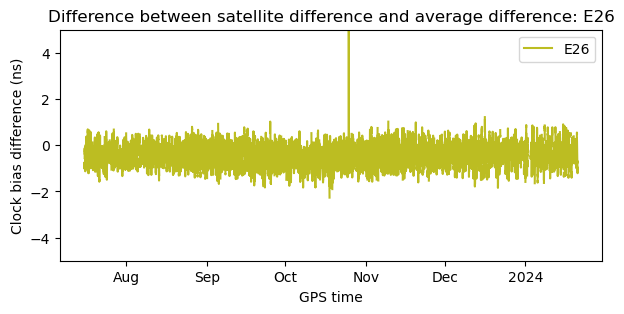

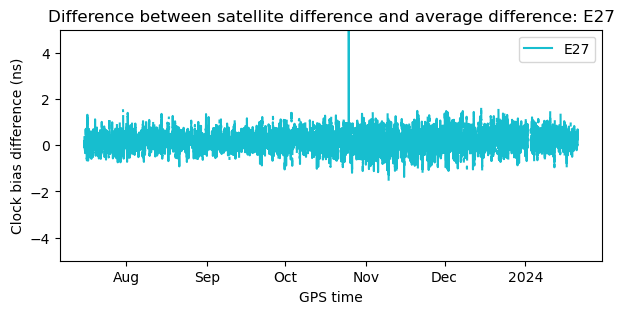

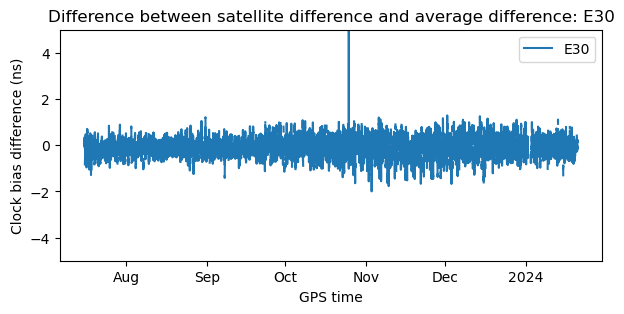

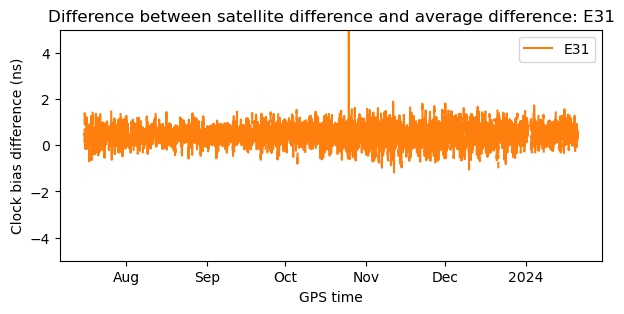

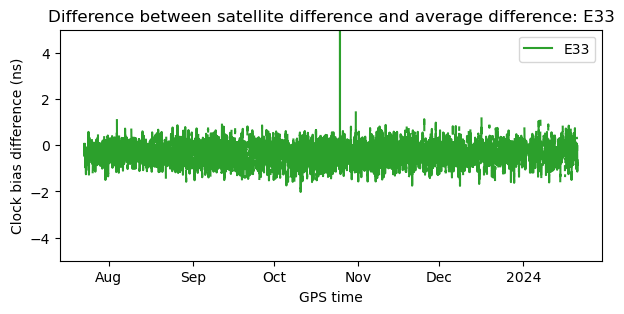

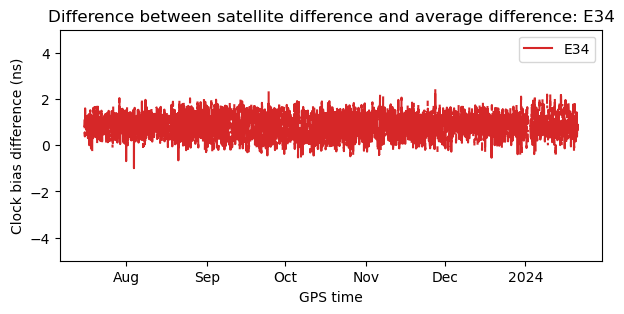

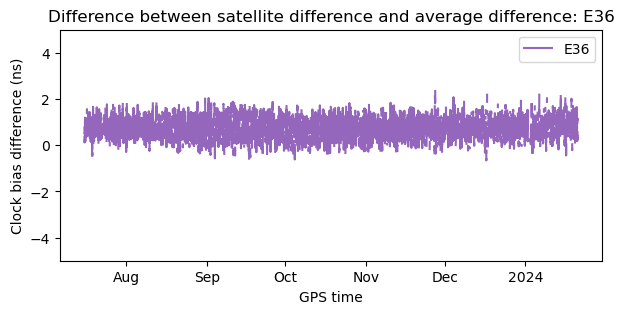

In [6]:
for j, sv in enumerate(diffs.sv.values):
    plt.figure()
    (diffs.sel(sv=sv) - diff0).plot(label=sv, color=f'C{j}')
    plt.title(f'Difference between satellite difference and average difference: {sv}')
    plt.xlabel('GPS time')
    plt.ylabel('Clock bias difference (ns)')
    plt.ylim(-5, 5)
    plt.legend();

In [7]:
offsets = {'GAUT', 'GAGP', 'GPUT'}
data = {}
for b in brdcs:
    with gzip.open(b) as f:
        ls = f.readlines()
    for line in ls:
        if str(line[:4], encoding='ascii') in offsets:
            line = str(line, encoding='ascii')
            off = line[:4]
            # some RINEX files contain D instead of E for the exponential notation
            a0 = float(line[4:22].replace('D', 'E'))
            a1 = float(line[22:38].replace('D', 'E'))
            tow = int(line[38:45])
            wn = int(line[45:50])
            gpst = (wn * 24 * 7 * 3600 + tow) * np.timedelta64(1, 's') + np.datetime64('1980-01-06T00:00:00', 'ns')
            d = data.setdefault(off, ([], [], []))
            # filter duplicated times
            if gpst not in d[0]:
                d[0].append(gpst)
                d[1].append(a0)
                d[2].append(a1)

In [8]:
timesys_a0 = xr.concat((xr.DataArray(data[off][1], coords={'time': data[off][0], 'offset': off}, dims=['time'])
                        for off in offsets), dim='offset')
timesys_a1 = xr.concat((xr.DataArray(data[off][2], coords={'time': data[off][0], 'offset': off}, dims=['time'])
                        for off in offsets), dim='offset')
timesys = xr.Dataset({'a0': timesys_a0, 'a1': timesys_a1})

/tmp/ipykernel_281809/1804335890.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  t[::3] = a0.time - 0.5 * day
/tmp/ipykernel_281809/1804335890.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  t[1::3] = a0.time + 0.5 * day
/tmp/ipykernel_281809/1804335890.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  t[2::3] = a0.time + 0.5 * day
/tmp/ipykernel_281809/1804335890.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y[::3] = a0 - a1 * 24 * 3600 * 0.5
/tmp/ipykernel_281809/1804335890

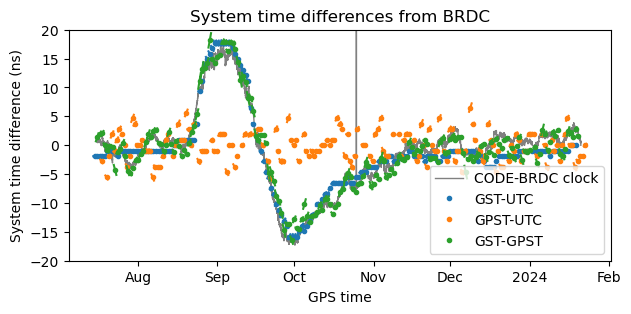

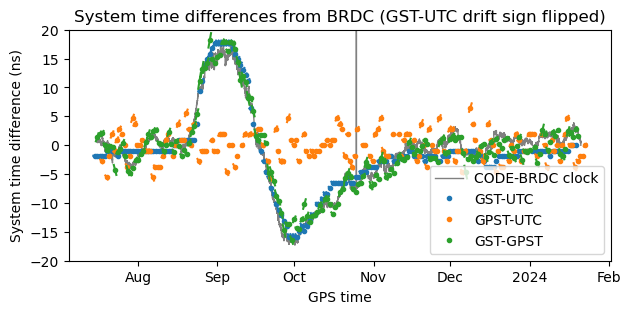

In [9]:
offset_labels = {'GPUT': 'GPST-UTC', 'GAGP': 'GST-GPST', 'GAUT': 'GST-UTC'}

for flip_gaut in [False, True]:
    plt.figure()
    (-diff0).plot(color='grey', linewidth=1, label='CODE-BRDC clock')
    for j, offset in enumerate(timesys.offset.values):
        a0 = 1e9 * timesys['a0'].sel(offset=offset)
        a0.plot(marker='.', linestyle='', label=offset_labels[offset], color=f'C{j}')
        a1 = 1e9 * timesys['a1'].sel(offset=offset)
        day = np.timedelta64(24 * 3600, 's')
        t = np.empty(3 * a0.time.size, dtype=a0.time.dtype)
        t[::3] = a0.time - 0.5 * day
        t[1::3] = a0.time + 0.5 * day
        t[2::3] = a0.time + 0.5 * day
        y = np.empty(3 * a0.size)
        y[::3] = a0 - a1 * 24 * 3600 * 0.5
        y[1::3] = a0 + a1 * 24 * 3600 * 0.5
        y[2::3] = np.nan
        if flip_gaut and offset == 'GAUT':
            # sanity check with opposite offset
            y[::3] = a0 + a1 * 24 * 3600 * 0.5
            y[1::3] = a0 - a1 * 24 * 3600 * 0.5       
        plt.plot(t, y, color=f'C{j}', label='_nolegend_')

    plt.legend()
    plt.title('System time differences from BRDC' + (' (GST-UTC drift sign flipped)' if flip_gaut else ''))
    plt.xlabel('GPS time')
    plt.ylabel('System time difference (ns)')
    plt.ylim(-20, 20)
    plt.legend()